# Simulate light curves - looking in data space

## Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sncosmo
from bayesn import SEDmodel
import matplotlib.patches as mpatches
import os
import pandas as pd
import pickle

## Make a list of SNe

In [2]:
directory = os.fsencode("/root/partiiiproject/Archive")
supernovae_names = ["sn2006hb"]
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".dat"):
        supernovae_names.append(filename[:-4])
        continue
    else:
        continue

## Dust laws

In [3]:
dust_laws = ('F99','F19', 'G23')
filter_yaml = "/root/partiiiproject/bayesn-filters/bayesn-filters/filters.yaml"

## Run Simulations

Current devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]
Currently working in /root/partiiiproject
Loading built-in model W22_model
Loading built-in reddening law F99
Current devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]
Currently working in /root/partiiiproject
Loading built-in model W22_model
Loading built-in reddening law F19
Current devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]
Currently working in /root/partiiiproject
Loading built-in model W22_model
Loading built-in reddening law G23


/tmp/ipykernel_15210/3520426204.py:95: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


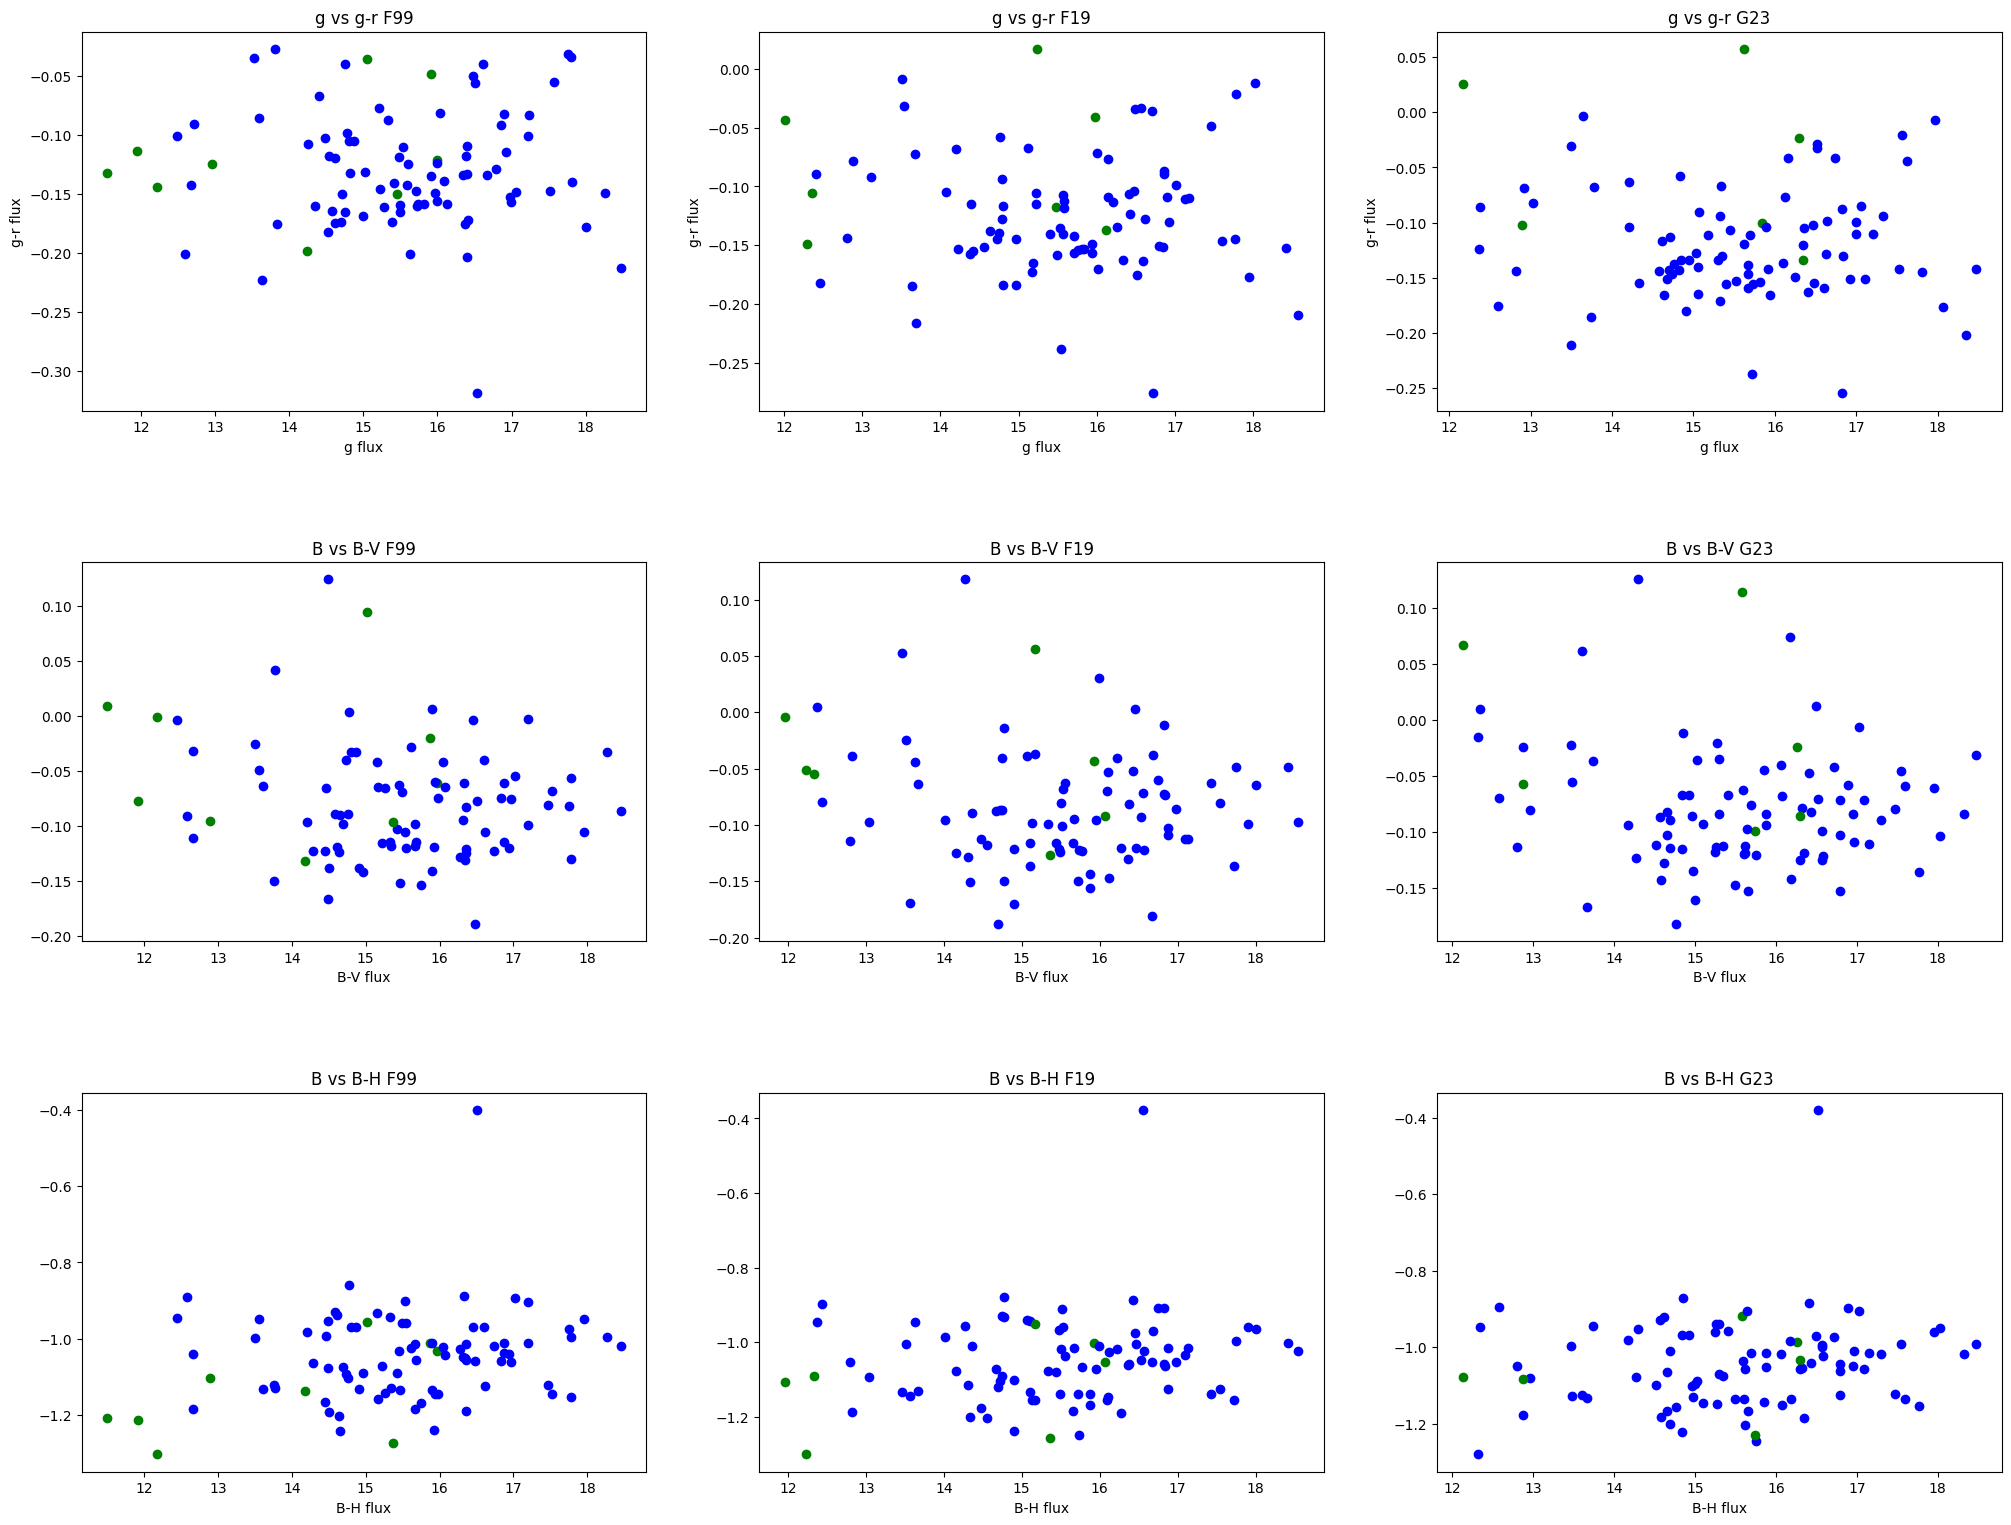

In [6]:
figure, axis = plt.subplots(3, len(dust_laws))
cs = ["k", "r", "b"]
for dust_law_index, dust_law in enumerate(dust_laws):
    model = SEDmodel(load_model='W22_model', filter_yaml = filter_yaml, load_redlaw=dust_law)
    for supernova_name in supernovae_names:
        if supernova_name== "sn2014J":
            continue
        
        #Get SN info from the original data file
        supernova_file = "/root/partiiiproject/Archive/"+supernova_name+".dat"
        meta, lcdata = sncosmo.read_snana_ascii(supernova_file, default_tablename='OBS')
        lcdata = lcdata['OBS'].to_pandas()
    
        #Extract useful properties from data file used in fits and simulation
        bands = ["g_CSP","r_CSP","B","V","H"]
        z = meta['REDSHIFT_FINAL']
        ebv_mw = meta['MWEBV']
        
        t = np.arange(-10,40,1)
    
        #Repeat through each dust law for that SN
    
            #Define directory where we should have our fits saved
        try:
            sampleChainsDir = "DustLawsFitOfAllSamples/"+supernova_name + dust_law + "_chains.pkl"
            sampleSummaryDir = "DustLawsFitOfAllSamples/"+supernova_name + dust_law + "_fit_summary.csv"
    
        except FileNotFoundError:
            continue
        #Check we have generated fits for this SN, otherwise move onto next SN
        try:
            #Load the chains with pickle
            with open(sampleChainsDir, 'rb') as file:
                chains = pickle.load(file)
        except FileNotFoundError:
            continue
    
        
        #Number of simulations to load
        N=1
        #Get values for simulation directly from chains, taking the mean
        fit_mu = np.mean(chains['mu'])
        fit_theta = np.mean(chains['theta'])
        fit_RV = np.mean(chains['RV'])
        fit_AV = np.mean(chains['AV'])
        fit_tmax = np.mean(chains['tmax'])
        fit_delM = np.mean(chains['delM'])
                
        #For epsilon we need some reshaping to get it in the correct form
        fit_eps_inner = chains['eps']
        fit_eps_inner = np.reshape(fit_eps_inner, (4, 250, 9, 6), order='F')
        fit_eps = np.zeros((4, 250, 11, 6))
        fit_eps[:,:,1:-1,:] = fit_eps_inner
        fit_eps = fit_eps.mean(axis = 1)
        fit_eps = fit_eps.mean(axis = 0)
        fit_eps = np.reshape(fit_eps, (1 , 11, 6))
    
        #Run simulation and get flux values
        try:
            sim = model.simulate_light_curve(t, N, bands, mu=fit_mu, theta=fit_theta,  z=0, ebv_mw=0, mag=True, write_to_files=False, AV=0, redlaw=dust_law, tmax=fit_tmax, eps=fit_eps)
        except ValueError:
            print("Value error for "+ supernova_name)
            continue
        flux, flux_err, params = sim
        flux = np.reshape(flux,(len(bands),len(t)))
        index_t_0 = np.where(t == 0)
        g=flux[0,index_t_0]
        r=flux[1,index_t_0]
        B=flux[2,index_t_0]
        V=flux[3,index_t_0]
        H=flux[4,index_t_0]
        if fit_AV>1:
            red_color = "g"
        elif fit_AV>2:
            red_color = "r"
        else:
            red_color = "b"
        #G vs g-r
        axis[0, dust_law_index].plot(g,g-r, color=red_color, marker='o')
        #B vs B-v
        axis[1, dust_law_index].plot(B,B-V, color=red_color, marker='o')
        #B vs B-H
        axis[2, dust_law_index].plot(B,B-H, color=red_color, marker='o')
    axis[0, dust_law_index].set_title("g vs g-r "+dust_law)
    axis[0, dust_law_index].set_xlabel("g flux")
    axis[0, dust_law_index].set_ylabel("g-r flux")
    axis[1, dust_law_index].set_title("B vs B-V "+dust_law)
    axis[1, dust_law_index].set_xlabel("B flux")
    axis[1, dust_law_index].set_xlabel("B-V flux")
    axis[2, dust_law_index].set_title("B vs B-H "+dust_law)
    axis[2, dust_law_index].set_xlabel("B flux")
    axis[2, dust_law_index].set_xlabel("B-H flux")

plt.subplots_adjust(left=0, right=3, bottom=0, top=3, wspace=0.2, hspace=0.4)
figure.show()

In [7]:
figure.savefig("/root/partiiiproject/DustLawsGeneralGraphs/"+supernova_name+dust_law+"ColorGraphs.png", bbox_inches='tight') 